In [ ]:
# Importing Necessary Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import warnings
import os
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings('ignore')

In [ ]:
TICKERS = {
    'tech': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'NFLX'],
    'finance': ['JPM', 'BAC', 'GS', 'WFC', 'C', 'MS', 'BLK', 'AXP'],
    'retail': ['WMT', 'TGT', 'COST', 'HD', 'LOW', 'NKE', 'MCD', 'SBUX'],
    'healthcare': ['JNJ', 'PFE', 'UNH', 'CVS', 'ABBV', 'MRK', 'TMO', 'LLY']
}

PERIOD_START = "2020-01-01"
PERIOD_END = "2024-01-01"

In [ ]:
ticker_list = [t for sector in TICKERS.values() for t in sector]
sector_map = {t: s for s, lst in TICKERS.items() for t in lst}

start_date = datetime.strptime(PERIOD_START, '%Y-%m-%d')
end_date = datetime.strptime(PERIOD_END, '%Y-%m-%d')

print(f'Ticker List: {ticker_list}')
print(f'Sector Map: {sector_map}')
print(f'Start Date: {start_date}')
print(f'End Date: {end_date}')

Ticker List: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'NFLX', 'JPM', 'BAC', 'GS', 'WFC', 'C', 'MS', 'BLK', 'AXP', 'WMT', 'TGT', 'COST', 'HD', 'LOW', 'NKE', 'MCD', 'SBUX', 'JNJ', 'PFE', 'UNH', 'CVS', 'ABBV', 'MRK', 'TMO', 'LLY']
Sector Map: {'AAPL': 'tech', 'MSFT': 'tech', 'GOOGL': 'tech', 'AMZN': 'tech', 'META': 'tech', 'NVDA': 'tech', 'TSLA': 'tech', 'NFLX': 'tech', 'JPM': 'finance', 'BAC': 'finance', 'GS': 'finance', 'WFC': 'finance', 'C': 'finance', 'MS': 'finance', 'BLK': 'finance', 'AXP': 'finance', 'WMT': 'retail', 'TGT': 'retail', 'COST': 'retail', 'HD': 'retail', 'LOW': 'retail', 'NKE': 'retail', 'MCD': 'retail', 'SBUX': 'retail', 'JNJ': 'healthcare', 'PFE': 'healthcare', 'UNH': 'healthcare', 'CVS': 'healthcare', 'ABBV': 'healthcare', 'MRK': 'healthcare', 'TMO': 'healthcare', 'LLY': 'healthcare'}
Start Date: 2020-01-01 00:00:00
End Date: 2024-01-01 00:00:00


In [ ]:
def download_stock_data(tickers, start_date, end_date):
    """
    Downloads daily adjusted stock data for all tickers between the given dates.
    Returns one DataFrame with columns:
    ['date', 'ticker', 'close', 'volume', 'sector', 'daily_return',
     'volatility_30d', 'volatility_90d']
    """
    print(f"Downloading {len(tickers)} tickers from {start_date.date()} to {end_date.date()}...")
    data = yf.download(
        tickers=" ".join(tickers),
        start=start_date.strftime("%Y-%m-%d"),
        end=end_date.strftime("%Y-%m-%d"),
        auto_adjust=True,
        group_by="ticker",
        threads=True,
        progress=False
    )

    all_frames = []

    for t in tickers:
        # Get close and volume data for this ticker
        temp = data[t][["Close", "Volume"]].copy()
        temp = temp.rename(columns={"Close": "close", "Volume": "volume"})
        temp["ticker"] = t
        temp["sector"] = sector_map[t]

        # 1. Calculate Daily Percent Change (Returns)
        temp["daily_return"] = temp["close"].pct_change() * 100

        # 2. Calculate 30-Day Rolling Volatility
        temp["volatility_30d"] = temp["daily_return"].rolling(window=30).std()

        # 3. Calculate 90-Day Rolling Volatility
        # Formula: Standard deviation of the last 90 daily returns
        temp["volatility_90d"] = temp["daily_return"].rolling(window=90).std()

        all_frames.append(temp)

    # Combine all stock data
    df = pd.concat(all_frames)
    df = df.reset_index().rename(columns={"Date": "date"})
    df = df.dropna(subset=["close", "volume"]).sort_values(["ticker", "date"]).reset_index(drop=True)

    print(f"  Columns: {list(df.columns)}")

    return df


In [ ]:
df = download_stock_data(ticker_list, start_date, end_date)
df.head()

  Columns: ['date', 'close', 'volume', 'ticker', 'sector', 'daily_return', 'volatility_30d', 'volatility_90d']


Price,date,close,volume,ticker,sector,daily_return,volatility_30d,volatility_90d
0,2020-01-02,72.468262,135480400,AAPL,tech,NaN,NaN,NaN
1,2020-01-03,71.763741,146322800,AAPL,tech,-0.972179,NaN,NaN
2,2020-01-06,72.335556,118387200,AAPL,tech,0.796803,NaN,NaN
3,2020-01-07,71.995346,108872000,AAPL,tech,-0.470322,NaN,NaN
4,2020-01-08,73.153511,132079200,AAPL,tech,1.608666,NaN,NaN


In [ ]:
df = df.dropna(subset=['daily_return', 'volatility_30d', 'volatility_90d'])
df.head()

Price,date,close,volume,ticker,sector,daily_return,volatility_30d,volatility_90d
90,2020-05-12,75.519020,162301200,AAPL,tech,-1.142791,2.635625,3.786712
91,2020-05-13,74.607178,200622400,AAPL,tech,-1.207434,2.653966,3.787554
92,2020-05-14,75.065529,158929200,AAPL,tech,0.614353,2.405577,3.787233
93,2020-05-15,74.621735,166348400,AAPL,tech,-0.591209,2.415245,3.787463
94,2020-05-18,76.379906,135178400,AAPL,tech,2.356111,2.393274,3.791602


In [ ]:
print(f'Remaining NaNs: {df.isnull().sum().sum()}')

Remaining NaNs: 0


In [ ]:
# Save the dataframe
df.to_csv('stock_data_cleaned.csv', index=False)

df_loaded = pd.read_csv('stock_data_cleaned.csv')
print(df_loaded.head(10))

         date      close     volume ticker sector  daily_return  \
0  2020-05-12  75.519020  162301200   AAPL   tech     -1.142791   
1  2020-05-13  74.607178  200622400   AAPL   tech     -1.207434   
2  2020-05-14  75.065529  158929200   AAPL   tech      0.614353   
3  2020-05-15  74.621735  166348400   AAPL   tech     -0.591209   
4  2020-05-18  76.379906  135178400   AAPL   tech      2.356111   
5  2020-05-19  75.938553  101729600   AAPL   tech     -0.577839   
6  2020-05-20  77.415398  111504800   AAPL   tech      1.944789   
7  2020-05-21  76.838257  102688800   AAPL   tech     -0.745512   
8  2020-05-22  77.332977   81803200   AAPL   tech      0.643847   
9  2020-05-26  76.809151  125522000   AAPL   tech     -0.677365   

   volatility_30d  volatility_90d  
0        2.635625        3.786712  
1        2.653966        3.787554  
2        2.405577        3.787233  
3        2.415245        3.787463  
4        2.393274        3.791602  
5        1.899982        3.786242  
6        1

# First ML Model: Hand-made Linear Regression

In [ ]:
import numpy as np
import pandas as pd

def add_intercept(X):
    """
    Add a column of 1s to X for the intercept term (β₀)

    Parameters:
    - X: Feature matrix (n_samples, n_features)

    Returns:
    - X with intercept column: (n_samples, n_features + 1)
    """
    n_samples = X.shape[0]
    ones = np.ones((n_samples, 1))
    X_with_intercept = np.hstack([ones, X])
    return X_with_intercept


def fit_linear_regression(X_train, y_train):
    """
    Fit linear regression using the Normal Equation

    Formula: β = (X^T X)^(-1) X^T y

    Parameters:
    - X_train: Training features (n_samples, n_features)
    - y_train: Training target (n_samples,)

    Returns:
    - beta: Coefficients array (n_features + 1,)
            First element is intercept, rest are feature coefficients
    """
    X = add_intercept(X_train)

    X_transpose = X.T

    XtX = np.dot(X_transpose, X)

    XtX_inv = np.linalg.inv(XtX)

    Xty = np.dot(X_transpose, y_train)

    beta = np.dot(XtX_inv, Xty)

    return beta


def predict_linear_regression(X_test, beta):
    """
    Make predictions using learned coefficients

    Parameters:
    - X_test: Test features (n_samples, n_features)
    - beta: Learned coefficients from training

    Returns:
    - predictions: Predicted values (n_samples,)
    """
    X = add_intercept(X_test)

    predictions = np.dot(X, beta)

    return predictions


def calculate_r_squared(y_true, y_pred):
    """
    Calculate R² (coefficient of determination)

    R² = 1 - (SS_residual / SS_total)

    Where:
    - SS_residual = Σ(y_true - y_pred)²
    - SS_total = Σ(y_true - mean(y_true))²

    Returns:
    - r_squared: Value between 0 and 1 (higher is better)
    """
    residuals = y_true - y_pred
    ss_residual = np.sum(residuals ** 2)

    y_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_mean) ** 2)

    r_squared = 1 - (ss_residual / ss_total)

    return r_squared


def calculate_mse(y_true, y_pred):
    """
    Calculate Mean Squared Error

    MSE = mean((y_true - y_pred)²)

    Returns:
    - mse: Mean squared error
    """
    squared_errors = (y_true - y_pred) ** 2
    mse = np.mean(squared_errors)

    return mse

In [ ]:
def prepare_stock_data(df, ticker, train_ratio=0.8):
    stock_df = df[df['ticker'] == ticker].copy()
    stock_df = stock_df.sort_values('date').reset_index(drop=True)

    feature_columns = ['daily_return', 'volatility_30d', 'volatility_90d', 'volume']
    X = stock_df[feature_columns].values

    stock_df['next_day_return'] = stock_df['close'].pct_change().shift(-1) * 100
    y = stock_df['next_day_return'].values

    X = X[:-1]
    y = y[:-1]

    valid_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=1)
    X = X[valid_indices]
    y = y[valid_indices]

    # Split into train/test
    n_samples = len(X)
    split_idx = int(n_samples * train_ratio)

    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]

    return X_train, X_test, y_train, y_test, feature_columns

In [ ]:
all_results = []

for ticker in ticker_list:
    X_train, X_test, y_train, y_test, feature_names = prepare_stock_data(df, ticker)

    beta_coefficients = fit_linear_regression(X_train, y_train)

    y_train_pred = predict_linear_regression(X_train, beta_coefficients)
    y_test_pred = predict_linear_regression(X_test, beta_coefficients)

    r2_train = calculate_r_squared(y_train, y_train_pred)
    r2_test = calculate_r_squared(y_test, y_test_pred)
    mse_train = calculate_mse(y_train, y_train_pred)
    mse_test = calculate_mse(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)

    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    all_results.append({
        'ticker': ticker,
        'sector': sector_map[ticker],
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'r2_train': r2_train,
        'r2_test': r2_test,
        'mse_train': mse_train,
        'mse_test': mse_test,
        'rmse_test': rmse_test,
        'beta_intercept': beta_coefficients[0],
        'beta_daily_return': beta_coefficients[1],
        'beta_vol_30d': beta_coefficients[2],
        'beta_vol_90d': beta_coefficients[3],
        'beta_volume': beta_coefficients[4],
        'train_residuals': train_residuals,
        'test_residuals': test_residuals,
        'mean_train_residual': np.mean(train_residuals),
        'mean_test_residual': np.mean(test_residuals),
        'std_train_residual': np.std(train_residuals),
        'std_test_residual': np.std(test_residuals)
    })

results_df = pd.DataFrame(all_results)

print('Overall Performance Metrics\n')
print(f'Stocks Analyzed: {len(ticker_list)}')
print(f'Sectors: {len(TICKERS)}\n')
print(f"Mean Test R²: {results_df['r2_test'].mean():.4f}")
print(f"Median Test R²: {results_df['r2_test'].median():.4f}")
print(f"Std Dev Test R²: {results_df['r2_test'].std():.4f}\n")
print(f"Mean Test RMSE: ${results_df['rmse_test'].mean():.2f}")
print(f"Median Test RMSE: ${results_df['rmse_test'].median():.2f}")
print(f"Std Dev Test RMSE: ${results_df['rmse_test'].std():.2f}\n")
print(f"Mean of Test Residuals: ${results_df['mean_test_residual'].mean():.2f}")
print(f"Std Dev of Test Residuals: ${results_df['std_test_residual'].mean():.2f}")

Overall Performance Metrics

Stocks Analyzed: 32
Sectors: 4

Mean Test R²: -0.0132
Median Test R²: -0.0072
Std Dev Test R²: 0.0338

Mean Test RMSE: $1.57
Median Test RMSE: $1.45
Std Dev Test RMSE: $0.50

Mean of Test Residuals: $0.04
Std Dev of Test Residuals: $1.56


In [ ]:
df

Price,date,close,volume,ticker,sector,daily_return,volatility_30d,volatility_90d
90,2020-05-12,75.519020,162301200,AAPL,tech,-1.142791,2.635625,3.786712
91,2020-05-13,74.607178,200622400,AAPL,tech,-1.207434,2.653966,3.787554
92,2020-05-14,75.065529,158929200,AAPL,tech,0.614353,2.405577,3.787233
93,2020-05-15,74.621735,166348400,AAPL,tech,-0.591209,2.415245,3.787463
94,2020-05-18,76.379906,135178400,AAPL,tech,2.356111,2.393274,3.791602
...,...,...,...,...,...,...,...,...
32187,2023-12-22,51.213169,19405500,WMT,retail,1.195092,1.762958,1.206798
32188,2023-12-26,51.134697,11679900,WMT,retail,-0.153226,1.739805,1.183192
32189,2023-12-27,51.615288,19896000,WMT,retail,0.939853,1.740742,1.177608
32190,2023-12-28,51.513947,16776000,WMT,retail,-0.196340,1.740499,1.177447


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

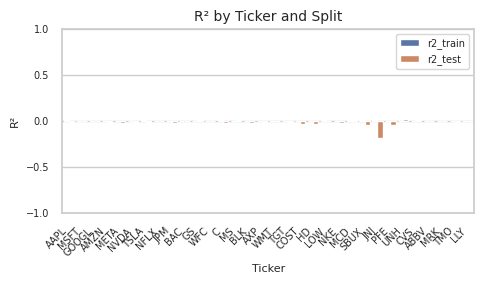

In [ ]:
plot_r2 = results_df.melt(
    id_vars=["ticker", "sector"],
    value_vars=["r2_train", "r2_test"],
    var_name="split",
    value_name="r2"
)

plt.figure(figsize=(5,3))
sns.barplot(data=plot_r2, x="ticker", y="r2", hue="split")
plt.title("R² by Ticker and Split", fontsize=10)
plt.xlabel("Ticker", fontsize=8)
plt.ylabel("R²", fontsize=8)
plt.ylim(-1, 1)
plt.xticks(rotation=45, ha="right", fontsize=7)
plt.yticks(fontsize=7)
plt.legend(title="", fontsize=7)
plt.tight_layout()
plt.show()

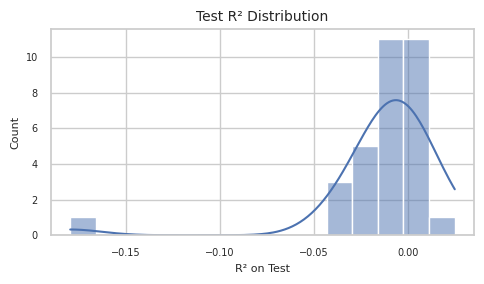

In [ ]:
plt.figure(figsize=(5,3))
sns.histplot(
    data=results_df,
    x=results_df["r2_test"].clip(-1, 1),
    bins=15,
    kde=True
)
plt.title("Test R² Distribution", fontsize=10)
plt.xlabel("R² on Test", fontsize=8)
plt.ylabel("Count", fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()

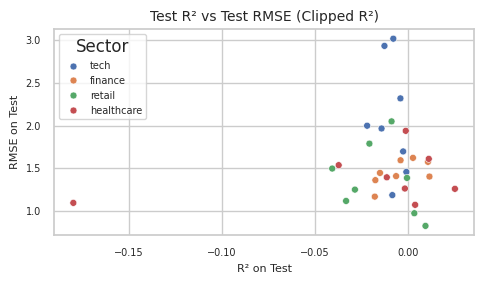

In [ ]:
df_clipped = results_df.copy()
df_clipped["r2_test_clipped"] = df_clipped["r2_test"].clip(-1, 1)

plt.figure(figsize=(5,3))
sns.scatterplot(
    data=df_clipped,
    x="r2_test_clipped",
    y="rmse_test",
    hue="sector",
    s=25
)
plt.title("Test R² vs Test RMSE (Clipped R²)", fontsize=10)
plt.xlabel("R² on Test", fontsize=8)
plt.ylabel("RMSE on Test", fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(title="Sector", fontsize=7)
plt.tight_layout()
plt.show()

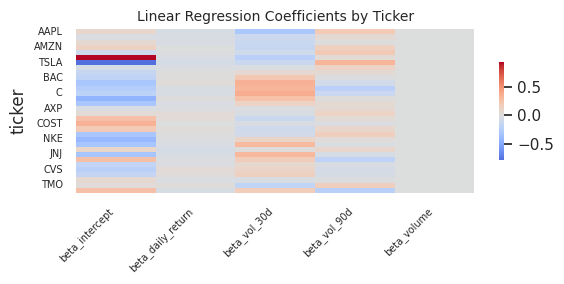

In [ ]:
beta_cols = [
    "beta_intercept",
    "beta_daily_return",
    "beta_vol_30d",
    "beta_vol_90d",
    "beta_volume",
]

coef_df = results_df.dropna(subset=beta_cols).set_index("ticker")[beta_cols]

plt.figure(figsize=(6,3))
sns.heatmap(
    coef_df,
    cmap="coolwarm",
    center=0,
    cbar_kws={"shrink": 0.6}
)
plt.title("Linear Regression Coefficients by Ticker", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()

- **R² by Ticker**  
  Shows how each model fits training data compared to real data. Large drops from train to test mean the patterns do not carry over. Negative test R² shows unstable relationships.

- **Test R² Distribution**  
  Most values fall below zero, which means returns are very hard to predict with these features. Shows limited consistency for certain tickers.

- **Test R² vs Test RMSE**  
  Low R² lines up with high RMSE. When the model explains less of the variation, errors rise. Predictability varies a lot across tickers.

- **Coefficient Heatmap**  
  Each ticker reacts differently to the same features. Strength and direction change across rows, showing that no single linear pattern fits the whole sector.

# Second ML Model: Ridge Regression

The initial Linear Regression model showed significant overfitting, with good training R2 but negative test R2 values. Ridge Regression addresses this by adding L2 regularization, which penalizes large coefficients and helps prevent overfitting.

Key Differences from NumPy Implementation:
- Adds regularization penalty (controlled by alpha parameter)
- Requires feature scaling for fair coefficient penalization
- Uses scikit-learn's optimized solver

will test multiple alpha values to find the optimal regularization strength for each ticker.

In [ ]:
def find_best_alpha_ridge(X_train, X_test, y_train, y_test, alphas=[0.01, 0.1, 1.0, 10.0, 100.0]):
    best_alpha = alphas[0]
    best_score = -np.inf

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_scaled, y_train)
        test_score = ridge.score(X_test_scaled, y_test)

        if test_score > best_score:
            best_score = test_score
            best_alpha = alpha

    return best_alpha, scaler

ridge_results = []

for ticker in ticker_list:
    X_train, X_test, y_train, y_test, feature_names = prepare_stock_data(df, ticker)

    best_alpha, scaler = find_best_alpha_ridge(X_train, X_test, y_train, y_test)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train_scaled, y_train)

    y_train_pred = ridge.predict(X_train_scaled)
    y_test_pred = ridge.predict(X_test_scaled)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)

    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    ridge_results.append({
        'ticker': ticker,
        'sector': sector_map[ticker],
        'best_alpha': best_alpha,
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'r2_train': r2_train,
        'r2_test': r2_test,
        'mse_train': mse_train,
        'mse_test': mse_test,
        'rmse_test': rmse_test,
        'ridge_intercept': ridge.intercept_,
        'ridge_coef_daily_return': ridge.coef_[0],
        'ridge_coef_vol_30d': ridge.coef_[1],
        'ridge_coef_vol_90d': ridge.coef_[2],
        'ridge_coef_volume': ridge.coef_[3],
        'mean_train_residual': np.mean(train_residuals),
        'mean_test_residual': np.mean(test_residuals),
        'std_train_residual': np.std(train_residuals),
        'std_test_residual': np.std(test_residuals)
    })

ridge_results_df = pd.DataFrame(ridge_results)

print('Ridge Regression: Overall Performance Metrics\n')
print(f'Mean Test R²: {ridge_results_df["r2_test"].mean():.4f}')
print(f'Median Test R²: {ridge_results_df["r2_test"].median():.4f}')
print(f'Std Dev Test R²: {ridge_results_df["r2_test"].std():.4f}\n')
print(f'Mean Test RMSE: ${ridge_results_df["rmse_test"].mean():.2f}')
print(f'Median Test RMSE: ${ridge_results_df["rmse_test"].median():.2f}')

Ridge Regression: Overall Performance Metrics

Mean Test R²: -0.0110
Median Test R²: -0.0057
Std Dev Test R²: 0.0290

Mean Test RMSE: $1.57
Median Test RMSE: $1.45


In [ ]:
comparison_df = pd.DataFrame({
    'Ticker': results_df['ticker'],
    'Sector': results_df['sector'],
    'NumPy_Test_R2': results_df['r2_test'],
    'Ridge_Test_R2': ridge_results_df['r2_test'],
    'NumPy_RMSE': results_df['rmse_test'],
    'Ridge_RMSE': ridge_results_df['rmse_test'],
    'R2_Improvement': ridge_results_df['r2_test'] - results_df['r2_test'],
    'RMSE_Improvement': results_df['rmse_test'] - ridge_results_df['rmse_test']
})

print('\nMODEL COMPARISON\n')
print(f'Mean Test R2 Improvement: {comparison_df["R2_Improvement"].mean():.4f}')
print(f'Mean RMSE Improvement: ${comparison_df["RMSE_Improvement"].mean():.4f}\n')
print(f'Tickers where Ridge performed better (R²): {(comparison_df["R2_Improvement"] > 0).sum()}/{len(comparison_df)}')
print(f'Tickers where Ridge performed better (RMSE): {(comparison_df["RMSE_Improvement"] > 0).sum()}/{len(comparison_df)}')


MODEL COMPARISON

Mean Test R2 Improvement: 0.0021
Mean RMSE Improvement: $0.0014

Tickers where Ridge performed better (R²): 24/32
Tickers where Ridge performed better (RMSE): 24/32


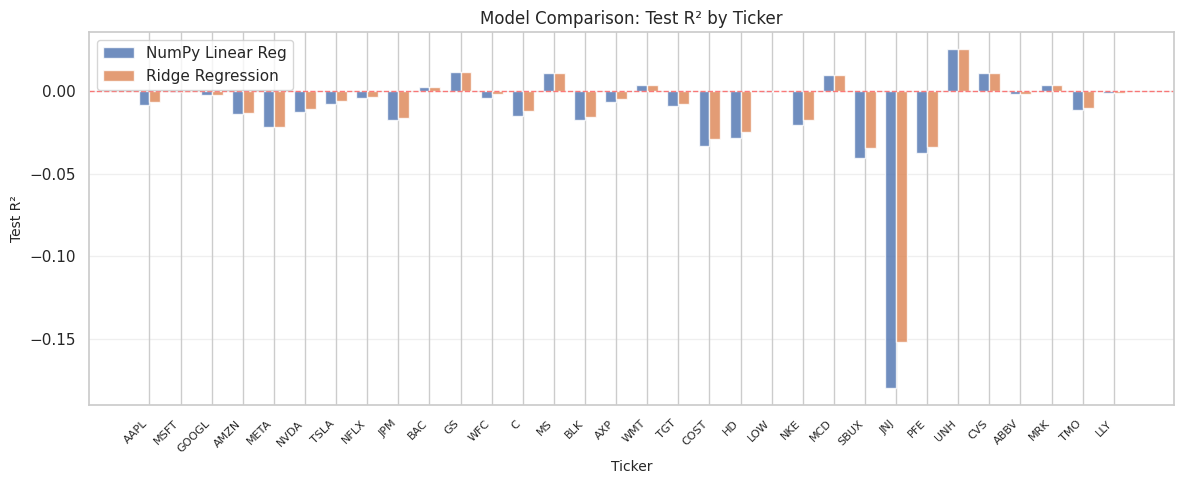

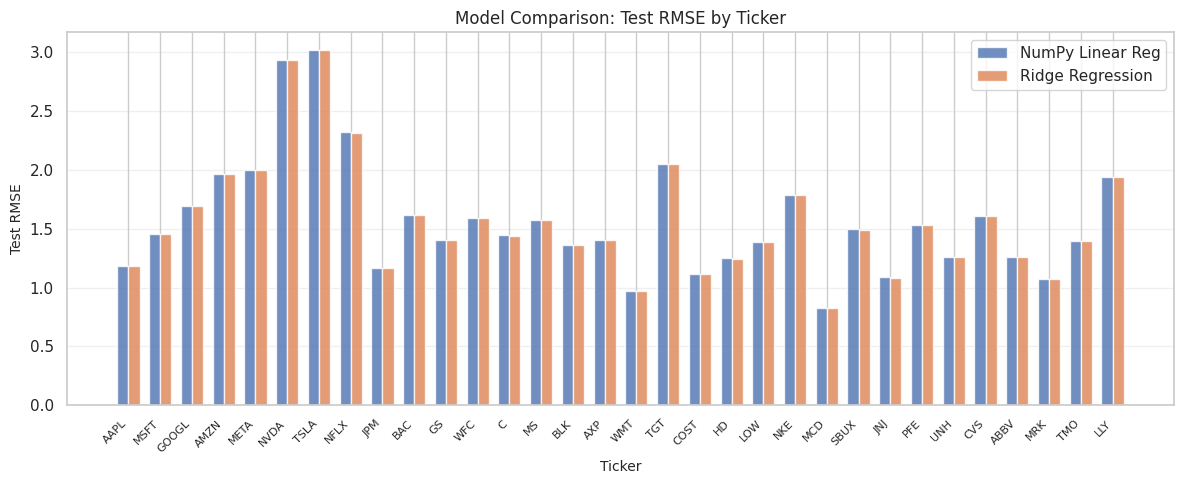

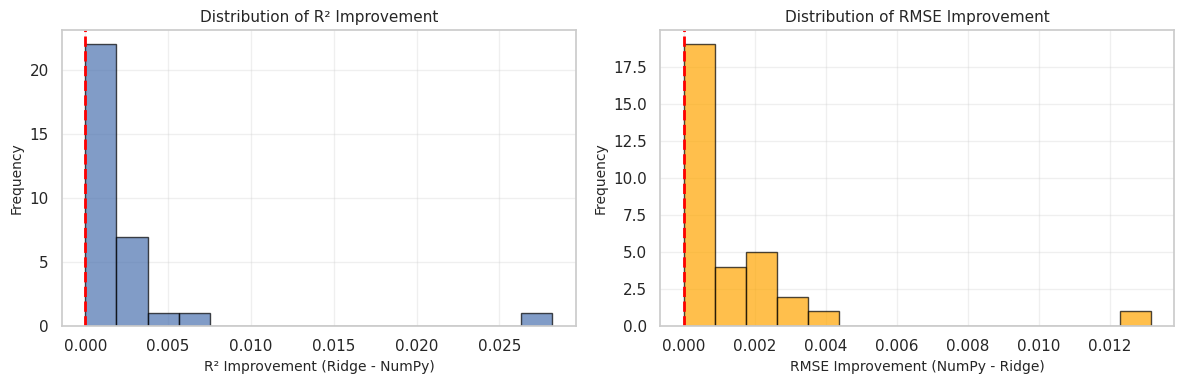

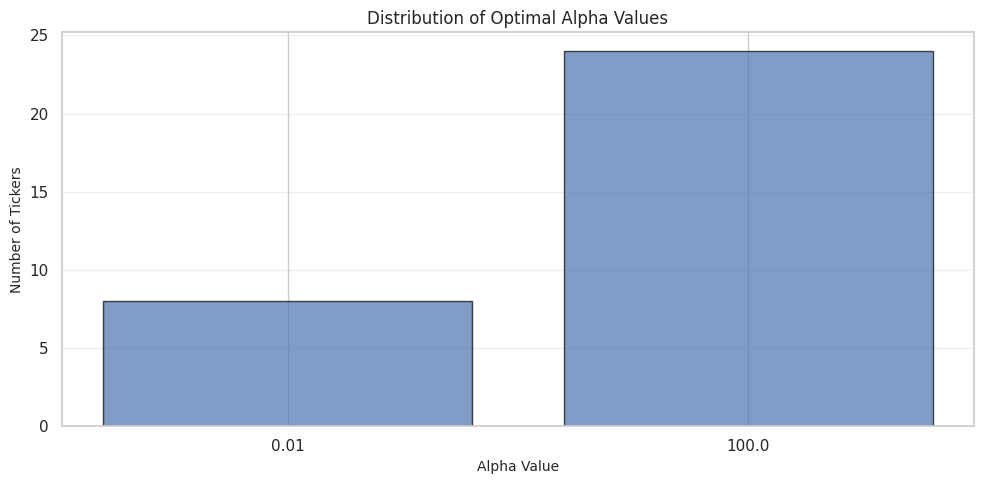

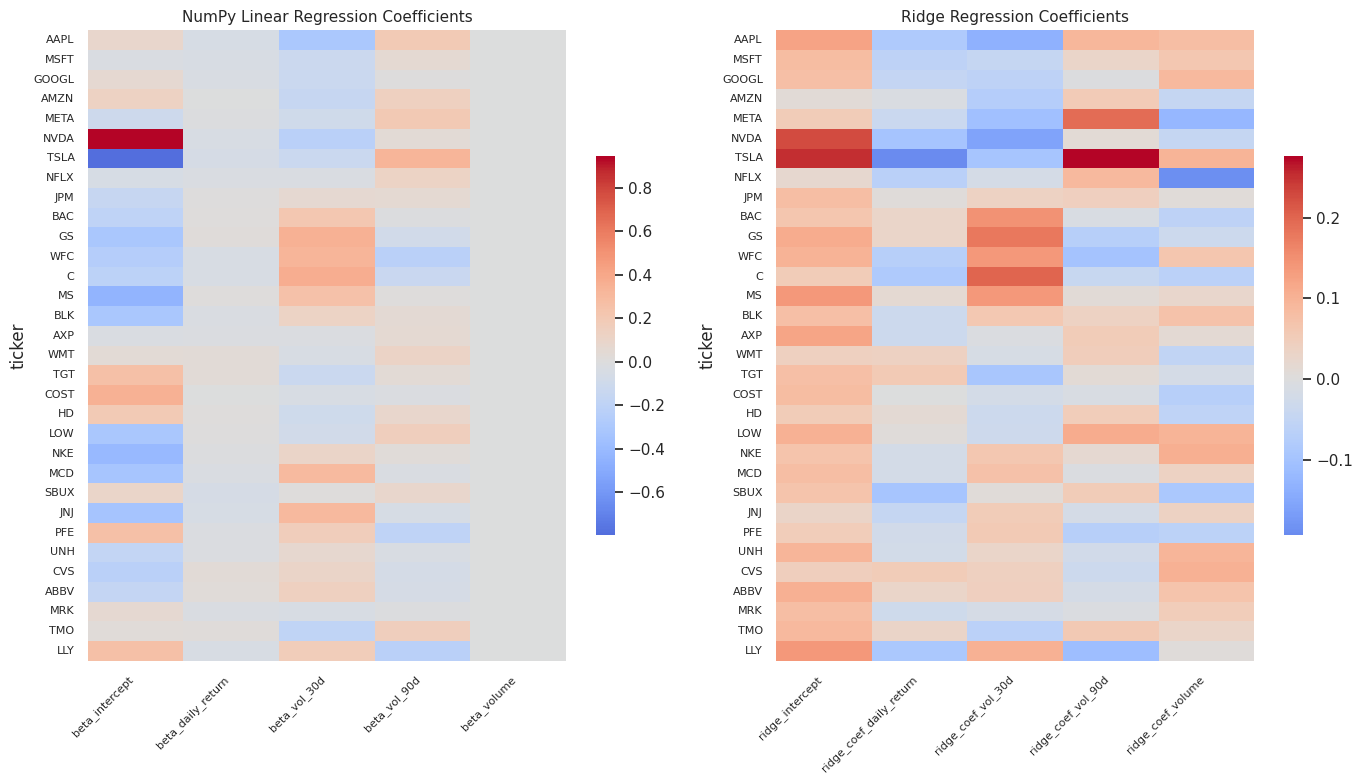

In [ ]:
# Side-by-Side R^2 Comparison
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['NumPy_Test_R2'], width, label='NumPy Linear Reg', alpha=0.8)
ax.bar(x + width/2, comparison_df['Ridge_Test_R2'], width, label='Ridge Regression', alpha=0.8)

ax.set_xlabel('Ticker', fontsize=10)
ax.set_ylabel('Test R²', fontsize=10)
ax.set_title('Model Comparison: Test R² by Ticker', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Ticker'], rotation=45, ha='right', fontsize=8)
ax.legend()
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# RMSE Comparison
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(x - width/2, comparison_df['NumPy_RMSE'], width, label='NumPy Linear Reg', alpha=0.8)
ax.bar(x + width/2, comparison_df['Ridge_RMSE'], width, label='Ridge Regression', alpha=0.8)

ax.set_xlabel('Ticker', fontsize=10)
ax.set_ylabel('Test RMSE', fontsize=10)
ax.set_title('Model Comparison: Test RMSE by Ticker', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Ticker'], rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Improvement Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(comparison_df['R2_Improvement'], bins=15, edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('R² Improvement (Ridge - NumPy)', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.set_title('Distribution of R² Improvement', fontsize=11)
ax1.grid(alpha=0.3)

ax2.hist(comparison_df['RMSE_Improvement'], bins=15, edgecolor='black', alpha=0.7, color='orange')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('RMSE Improvement (NumPy - Ridge)', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title('Distribution of RMSE Improvement', fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Alpha Distribution
plt.figure(figsize=(10, 5))
alpha_counts = ridge_results_df['best_alpha'].value_counts().sort_index()
plt.bar(alpha_counts.index.astype(str), alpha_counts.values, edgecolor='black', alpha=0.7)
plt.xlabel('Alpha Value', fontsize=10)
plt.ylabel('Number of Tickers', fontsize=10)
plt.title('Distribution of Optimal Alpha Values', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Coefficient Comparison Heatmap
ridge_coef_cols = [
    'ridge_intercept',
    'ridge_coef_daily_return',
    'ridge_coef_vol_30d',
    'ridge_coef_vol_90d',
    'ridge_coef_volume'
]

ridge_coef_df = ridge_results_df.set_index('ticker')[ridge_coef_cols]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

sns.heatmap(coef_df, cmap='coolwarm', center=0, cbar_kws={'shrink': 0.6}, ax=ax1)
ax1.set_title('NumPy Linear Regression Coefficients', fontsize=11)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=8)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=8)

sns.heatmap(ridge_coef_df, cmap='coolwarm', center=0, cbar_kws={'shrink': 0.6}, ax=ax2)
ax2.set_title('Ridge Regression Coefficients', fontsize=11)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=8)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=8)

plt.tight_layout()
plt.show()

## Initial Approach

The main question was whether daily stock returns could be predicted using a small set of historical features. We implemented two linear regression approaches trained separately for each ticker: a manual NumPy implementation and Ridge Regression with scikit-learn. The features included daily return, rolling volatility measures, and recent volume. The goal was to see whether simple linear relationships contained enough signal to forecast short-term movements, and whether regularization could address overfitting issues.

## Model Results

The comparison between training and test R² values showed clear overfitting in the NumPy Linear Regression. Training R² values ranged from moderate to fairly strong across many tickers, indicating the models fit historical data well. However, test R² values dropped sharply for nearly every ticker, with most being negative. The coefficient heatmap highlighted how differently each ticker responded to the same features, suggesting no shared linear pattern describes sector behavior.

Ridge Regression was implemented to address overfitting through L2 regularization. We tested multiple alpha values for each ticker and selected the optimal regularization strength. The regularization provided modest improvements, with mean test R² improving slightly and coefficient magnitudes decreasing. However, most test R² values remained negative, showing that while regularization reduced overfitting, it could not create predictive signal where little exists. The coefficient comparison heatmap clearly shows Ridge's smaller, more stable coefficients compared to the NumPy implementation.

## Conclusions

Both models demonstrate that predicting daily stock returns with simple linear features is extremely challenging. While Ridge's regularization reduced overfitting, the fundamental issue remains: daily returns contain high noise relative to signal. The results show that overfitting is partially addressable through regularization, but the limited predictive power stems from inadequate features and the inherent unpredictability of short-term market movements. More advanced approaches would require richer feature sets, non-linear models, or longer prediction horizons to reveal meaningful structure.